In [4]:
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten

import pandas as pd
import io
import requests
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")    

In [5]:
#Extract data from Github
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_features_3.csv"
s = requests.get(url).content
training_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_target_3.csv"
s = requests.get(url).content
training_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_features_3.csv"
s = requests.get(url).content
testing_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_target_3.csv"
s = requests.get(url).content
testing_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')


#Define precision, recall, and f1 for analysis
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Train on 2454 samples, validate on 614 samples
Epoch 1/10
2454/2454 [==============================] - 1s 209us/step - loss: 0.4493 - accuracy: 0.8309 - f1_m: 0.0663 - precision_m: 0.1753 - recall_m: 0.0427 - val_loss: 0.5275 - val_accuracy: 0.8046 - val_f1_m: 0.3532 - val_precision_m: 0.8500 - val_recall_m: 0.2635
Epoch 2/10
2454/2454 [==============================] - 0s 125us/step - loss: 0.4327 - accuracy: 0.8513 - f1_m: 0.2560 - precision_m: 0.6385 - recall_m: 0.1689 - val_loss: 0.5206 - val_accuracy: 0.8046 - val_f1_m: 0.3532 - val_precision_m: 0.8500 - val_recall_m: 0.2635
Epoch 3/10
2454/2454 [==============================] - 0s 131us/step - loss: 0.4235 - accuracy: 0.8525 - f1_m: 0.2909 - precision_m: 0.6732 - recall_m: 0.1943 - val_loss: 0.5094 - val_accuracy: 0.8046 - val_f1_m: 0.3532 - val_precision_m: 0.8500 - val_recall_m: 0.2635
Epoch 4/10
2454/2454 [==============================] - 0s 126us/step - loss: 0.4223 - accuracy: 0.8549 - f1_m: 0.2772 - precision_m: 0.6255 - 

<Figure size 432x288 with 0 Axes>

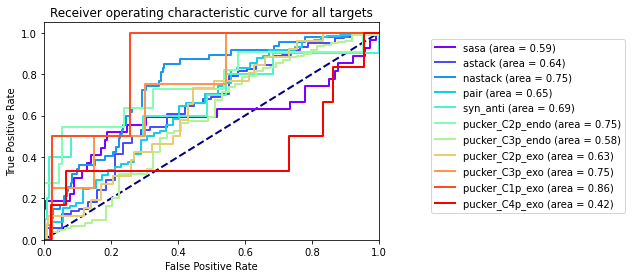

In [6]:
Total_Data = pd.DataFrame(columns = ['Parameter','F1-score'])

import matplotlib.cm as cm

feature_list = ['sasa','astack','nastack','pair','syn_anti','pucker_C2p_endo','pucker_C3p_endo','pucker_C2p_exo','pucker_C3p_exo','pucker_C1p_exo','pucker_C4p_exo']
colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

i=0
plt.figure()
lw = 2
__, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

for structural_feature in feature_list:
  
  trainX = training_X.values
  training_y_2 = training_y[[structural_feature]]
  trainy = training_y_2.values
  testX = testing_X.values
  testing_y_2 = testing_y[[structural_feature]]
  testy = testing_y_2.values

  scaler = StandardScaler()
  scaler.fit(trainX)
  trainX_scaled = scaler.transform(trainX)
  testX_scaled = scaler.transform(testX)

#Expand dimensions of data so can be inputted into convolutional layers
  trainX_expanded = np.expand_dims(trainX, axis=2)
  testX_expanded = np.expand_dims(testX, axis=2)

  model = Sequential()
  model.add(Conv1D(filters=6, kernel_size=5, activation='sigmoid', input_shape=(trainX_expanded.shape[1],trainX_expanded.shape[2])))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='sigmoid'))
  model.add(Dense(trainX_expanded.shape[2], activation = 'sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', f1_m,precision_m, recall_m])
  if i ==1:
    print(model.summary())
  model.fit(trainX_expanded, trainy, nb_epoch = 10, batch_size = 32, verbose = 1, validation_split = 0.2)

  y_pred = model.predict(testX_expanded)
  y_pred = np.float64(y_pred)
  y_true = np.array([testy[i][0] for i in range(len(testy))])
  y_pred = np.array([y_pred[i][0] for i in range(len(y_pred))])
  f1 = f1_m(y_true,y_pred).numpy()
  temp = pd.DataFrame([[structural_feature,f1]], columns = ['Parameter','F1-score'])
  Total_Data = Total_Data.append(temp)

  AUC = sklearn.metrics.roc_auc_score(y_true, y_pred, average = 'weighted')
  fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_true, y_pred, pos_label = 1)
  
  ax.plot(fpr, tpr, color=colors[i],
          lw=lw, label=f'{structural_feature} (area = %0.2f)' % AUC)
  
  i+=1

print(Total_Data)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for all targets')
plt.legend(loc="lower right", bbox_to_anchor=(1.75, 0.1))
plt.show()